In [4]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, MetricVisualizer
import matplotlib.pyplot as plt
import shap

ModuleNotFoundError: No module named 'shap'

In [5]:
df = pd.read_csv('data/train.csv')
df

,record_id,day,label,os,is_mobile,country,pageviews,visits,hits,bounces,campaign,traffic_source,medium,device_category,engagement_type,split_seg
0,-1595987367179803479,2016-09-29,0,iOS,True,United States,4,1,6,0,(not set),siliconvalley.about.com,referral,mobile,Not Socially Engaged,8
1,-5833097415970432540,2016-09-29,0,iOS,True,United States,13,1,17,0,(not set),duckduckgo.com,referral,mobile,Not Socially Engaged,8
2,-3190546040571234557,2016-09-29,0,iOS,True,United States,11,1,18,0,(not set),siliconvalley.about.com,referral,mobile,Not Socially Engaged,8
3,1148536304983779444,2016-09-29,0,iOS,True,Taiwan,7,1,8,0,(not set),m.facebook.com,referral,mobile,Not Socially Engaged,8
4,5582351582810443098,2016-09-29,0,iOS,True,United States,1,1,1,1,(not set),m.facebook.com,referral,mobile,Not Socially Engaged,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829280,-8146798225211754676,2017-03-24,0,Macintosh,False,United States,2,1,2,0,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged,8
829281,-6652057389730016009,2017-03-24,0,Macintosh,False,United States,2,1,2,0,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged,8
829282,912366749753247557,2017-03-24,0,Macintosh,False,Brazil,2,1,2,0,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged,8
829283,3062937092292263243,2017-03-24,0,Macintosh,False,Spain,2,1,2,0,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged,8


In [5]:
train = df.loc[df.split_seg < 8]
test = df.loc[df.split_seg >= 8]

In [6]:
test.nunique()

record_id          175810
day                    69
label                   2
os                     16
is_mobile               2
country               201
pageviews             144
visits                  1
hits                  179
bounces                 2
campaign                7
traffic_source        163
medium                  7
device_category         3
engagement_type         1
split_seg               2
dtype: int64

In [7]:
test.dtypes

record_id           int64
day                object
label               int64
os                 object
is_mobile            bool
country            object
pageviews           int64
visits              int64
hits                int64
bounces             int64
campaign           object
traffic_source     object
medium             object
device_category    object
engagement_type    object
split_seg           int64
dtype: object

In [26]:
target = 'label'

c_features = ['os',
              'country',
              'campaign',
              'traffic_source',
              'medium',
              'device_category',
              'engagement_type']

n_features = ['pageviews',
              'visits',
              'hits',
              'bounces',
              'is_mobile']

# train_X = train.drop('label', axis=1)
train_X = train[n_features+c_features]
train_data = Pool(train_X,
                  label=train[[target]],
                  cat_features=c_features,
                  feature_names=list(train_X.columns),
                  has_header=True)

# # test_X = test.drop('label', axis=1)
test_X = test[n_features+c_features]
test_data = Pool(test_X,
                  label=test[[target]],
                  cat_features=c_features,
                  feature_names=list(test_X.columns),
                  has_header=True)

In [27]:
train_X

,pageviews,visits,hits,bounces,is_mobile,os,country,campaign,traffic_source,medium,device_category,engagement_type
5412,1,1,1,1,True,iOS,United States,(not set),dfa,cpm,mobile,Not Socially Engaged
5413,1,1,1,1,False,Windows,United States,(not set),dfa,cpm,desktop,Not Socially Engaged
5414,7,1,14,0,False,Chrome OS,United States,(not set),dfa,cpm,desktop,Not Socially Engaged
5415,4,1,5,0,False,Chrome OS,United States,(not set),dfa,cpm,desktop,Not Socially Engaged
5416,1,1,1,1,False,Chrome OS,United States,(not set),dfa,cpm,desktop,Not Socially Engaged
...,...,...,...,...,...,...,...,...,...,...,...,...
826906,1,1,1,1,False,Macintosh,United States,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged
826907,2,1,3,0,False,Macintosh,Canada,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged
826908,1,1,1,1,False,Macintosh,Denmark,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged
826909,2,1,2,0,False,Macintosh,Poland,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged


## Train Default Model w/ Early Stopping

In [28]:
model = CatBoostClassifier(iterations=1000,
                           loss_function='Logloss',
                           verbose=False,
                           train_dir='cb_default')

model.fit(train_data,
          eval_set=test_data,
          early_stopping_rounds=10)

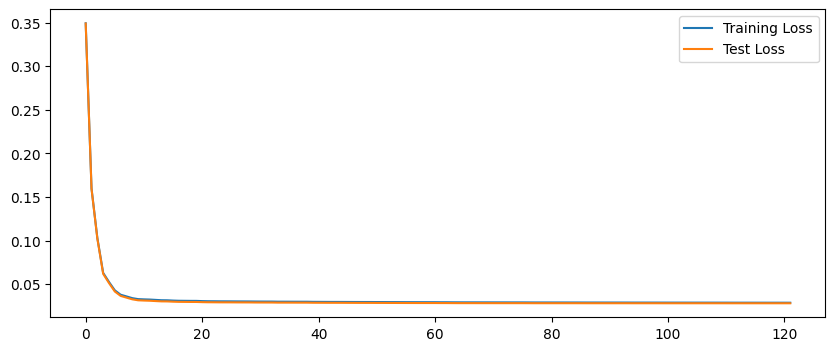

In [29]:
plt.figure(figsize=(10,4))
x = range(len(model.evals_result_['learn']['Logloss']))
plt.plot(x,
         model.evals_result_['learn']['Logloss'],
         label='Training Loss')
plt.plot(x,
         model.evals_result_['validation']['Logloss'],
         label='Test Loss')
plt.legend()

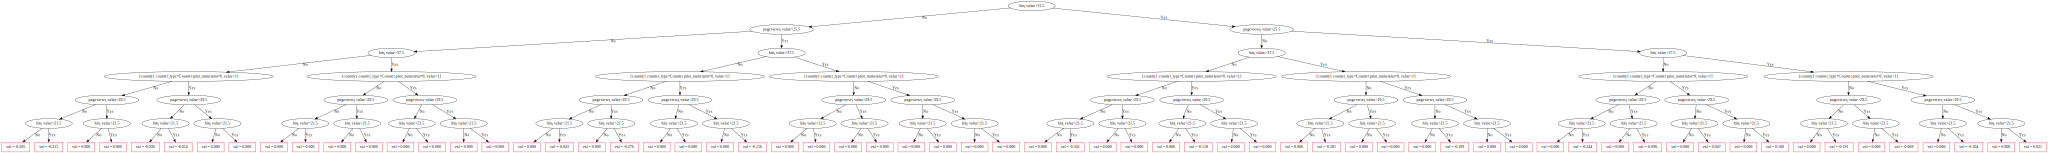

In [30]:
model.plot_tree(pool=test_data,tree_idx=10)

In [31]:
imps = pd.DataFrame([ (f[0], f[1]) for f in zip(train_X.columns, model.get_feature_importance()) ], columns=['Feature', 'Importance'])
imps.sort_values('Importance', ascending=False)

,Feature,Importance
2,hits,32.582830
0,pageviews,24.464192
3,bounces,23.873629
6,country,13.745455
9,medium,2.773240
5,os,1.195394
4,is_mobile,0.833260
10,device_category,0.314444
8,traffic_source,0.212116
7,campaign,0.005442


In [32]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(test_data)

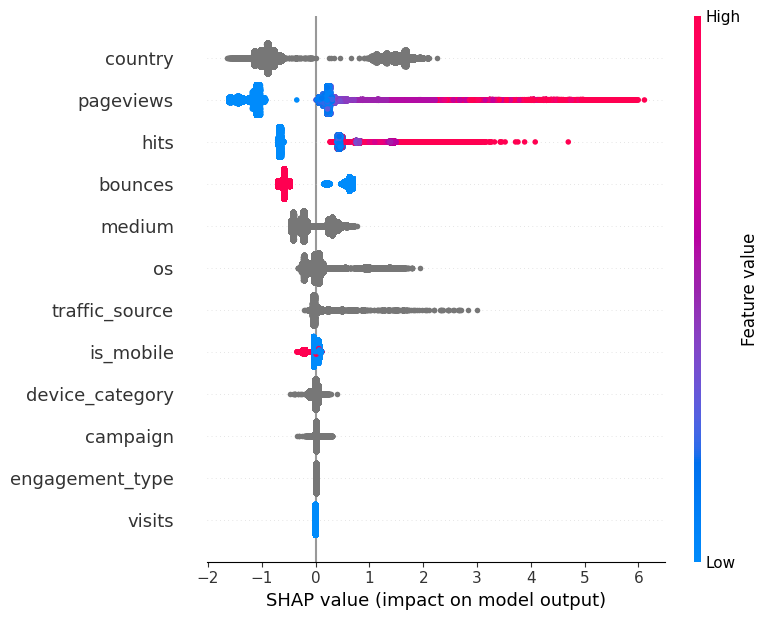

In [33]:
shap.summary_plot(shap_values, test_X)

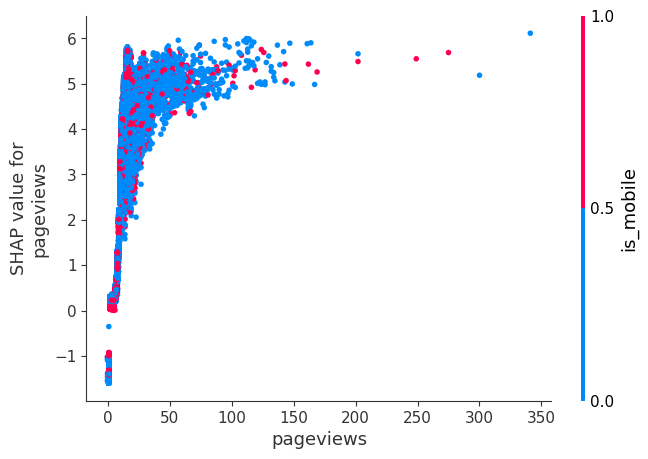

In [34]:
shap.dependence_plot("pageviews", 
                     shap_values, 
                     test_X, 
                     interaction_index="is_mobile")

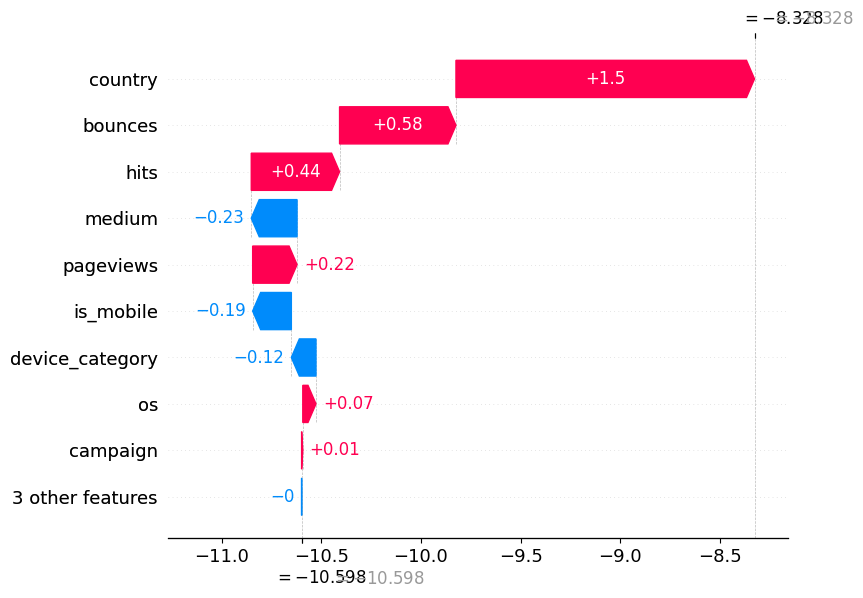

In [35]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names=test_X.columns)

In [36]:
shap.plots.force(explainer.expected_value, shap_values[0], feature_names=test_X.columns)

## Generate Preds for Validation Data

In [37]:
val = pd.read_csv('data/val.csv')
val

,record_id,day,label,os,is_mobile,country,pageviews,visits,hits,bounces,campaign,traffic_source,medium,device_category,engagement_type
0,1366269133963698001,2017-07-11,0,iOS,True,United States,6,1,6,0,AW - Dynamic Search Ads Whole Site,google,cpc,mobile,Not Socially Engaged
1,-8557488370289751739,2017-07-11,0,iOS,True,United States,7,1,7,0,AW - Dynamic Search Ads Whole Site,google,cpc,mobile,Not Socially Engaged
2,1023250374177822763,2017-07-11,0,iOS,True,United States,7,1,7,0,AW - Dynamic Search Ads Whole Site,google,cpc,tablet,Not Socially Engaged
3,-2087316440335153155,2017-07-11,0,iOS,True,United States,21,1,21,0,AW - Dynamic Search Ads Whole Site,google,cpc,mobile,Not Socially Engaged
4,-320817867082081271,2017-07-11,1,iOS,True,United States,44,1,58,0,AW - Dynamic Search Ads Whole Site,google,cpc,mobile,Not Socially Engaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74363,-1940301680148937584,2017-07-09,0,Macintosh,False,United States,1,1,1,1,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged
74364,9087636071844814629,2017-07-09,0,Macintosh,False,United States,2,1,2,0,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged
74365,6890548954689680223,2017-07-09,0,Macintosh,False,United States,3,1,3,0,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged
74366,1335250507176481031,2017-07-09,0,Macintosh,False,Japan,1,1,1,1,Data Share Promo,Partners,affiliate,desktop,Not Socially Engaged


In [39]:
val_X = val[n_features+c_features]
val_data = Pool(val_X,
              label=val[[target]],
              cat_features=c_features,
              feature_names=list(val_X.columns),
              has_header=True)

preds_proba = model.predict_proba(val_data)

In [41]:
preds_proba.shape

(74368, 2)

In [49]:
model.classes_

array([0, 1])

In [53]:
preds_proba[:,1]

array([2.50653347e-04, 4.39833349e-04, 4.39833349e-04, ...,
       4.23069559e-04, 1.01160039e-06, 1.01160039e-06])

In [42]:
val.shape

(74368, 15)

In [54]:
val['cb_default_pred'] = preds_proba[:,1]
val.to_csv('comparison/validate_cb_dfault.csv', index=False)

In [ ]:
file = open('/gcs/BUCKET/data.csv', 'r')

In [11]:
import random

In [19]:
l = list(df.split_seg.unique())

[ random.choice(l) for s in range(2) ]

[3, 4]

In [22]:
l.pop()

3

In [23]:
l

[8, 5, 2, 0, 4, 1, 7, 9]